## Main Task: Pretrained ResNet-18 and ResNet-34

The ResNet architecture introduces residual connections, which help mitigate the vanishing gradient problem in deep networks by allowing gradients to flow directly through shortcut connections. ResNet-18 is one of the lighter and more computationally efficient models in the ResNet family, with 18 layers containing 4 stages consisting of two residual blocks each. As the Flowers dataset is relatively small, we utilize transfer learning to take advantage of the pre-trained features learned from ImageNet and fine-tune the model to adapt to the flower classification task.

### Installing Libraries

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0
from tqdm import tqdm
import torchvision.models as models
import matplotlib.pyplot as plt

### Preparing Flowers102 Dataset

The Flowers102 dataset is already available to be fetched via the Torchvision library. To prepare the dataset, we transform the images to be of size 224x224 so that they are in line with the ResNet input size. We also normalize them so that their mean and standard deviation are in line with the pretrained statistics from ImageNet.

In [3]:
# resize images to 224x224 in line with ResNet input size, normalize images so mean and std are in line with pretrained statistics
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# load the datasets
train_set = Flowers102(root='data/flowers102', split='train', transform=transform, download=True)
val_set = Flowers102(root='data/flowers102', split='val', transform=transform, download=True)
test_set = Flowers102(root='data/flowers102', split='test', transform=transform, download=True)

In [4]:
print(f"Size of training set: {len(train_set)}")
print(f"Size of validation set: {len(val_set)}")
print(f"Size of test set: {len(test_set)}")

Size of training set: 1020
Size of validation set: 1020
Size of test set: 6149


In [5]:
# create data loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

### Training ResNet-18 From Scratch

ResNet-18 is one of the lighter and more computationally efficient models in the ResNet family, with 18 layers containing 4 stages consisting of two residual blocks each.

We train a ResNet-18 model from scratch on the Flowers102 dataset. This will serve as a baseline for comparison against the later experiments using transfer learning on ResNet-18. This model achieved a test accuracy of 84.76% on the test set.

In [6]:
# early stopper
class EarlyStopper:
    def __init__(self, patience=5, verbose=True, model_path='model.pth'):
        self.patience = patience
        self.counter = 0
        self.best_score = float('inf') 
        self.verbose = verbose
        self.model_path = model_path

    def early_stop(self, val_loss, model):
        if val_loss < self.best_score:
            self.best_score = val_loss 
            self.counter = 0 
            torch.save(model.state_dict(), self.model_path)
        else:
            self.counter += 1
           
        if self.counter >= self.patience:
            if self.verbose:
                print("Early stopping...")
            return True
        return False

In [7]:
# Training function
def train_model(model, train_loader, val_loader, loss_fn, optimizer, earlystopper, num_epochs=100):
    train_losses_history = []
    val_losses_history = []
    train_accuracies_history = []
    val_accuracies_history = []
    for epoch in range(num_epochs):
        # training mode
        model.train() 
        running_loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            # backward pass and optimization
            loss.backward()
            optimizer.step()
        

        average_train_loss = running_loss / total
        average_train_accuracy = correct / total
        train_losses_history.append(average_train_loss)
        train_accuracies_history.append(average_train_accuracy)

        
       # validation mode
        model.eval()
        correct = 0
        total = 0
        running_loss = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                

        average_val_loss = running_loss / total
        average_val_accuracy = correct / total
        val_losses_history.append(average_val_loss)
        val_accuracies_history.append(average_val_accuracy)

        print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Train Accuracy: {average_train_accuracy:.4f}, Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {average_val_accuracy:.4f}")

        if earlystopper.early_stop(average_val_loss, model):
            break 
    
    return train_losses_history, train_accuracies_history, val_losses_history, val_accuracies_history

In [8]:
# basic resnet from scratch
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 102)  # 102 flower classes
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
earlystopper = EarlyStopper(model_path='resnet18_from_scratch.pth')
train_losses_history, train_accuracies_history, val_losses_history, val_accuracies_history = train_model(model, train_loader, val_loader, loss_fn, optimizer, earlystopper, num_epochs=100)

c:\Users\Sheryl\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sheryl\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [0/100], Train Loss: 0.1097, Train Accuracy: 0.2471, Validation Loss: 0.0728, Validation Accuracy: 0.4431
Epoch [1/100], Train Loss: 0.0365, Train Accuracy: 0.7725, Validation Loss: 0.0559, Validation Accuracy: 0.5373
Epoch [2/100], Train Loss: 0.0123, Train Accuracy: 0.9353, Validation Loss: 0.0455, Validation Accuracy: 0.6392
Epoch [3/100], Train Loss: 0.0048, Train Accuracy: 0.9843, Validation Loss: 0.0338, Validation Accuracy: 0.7422
Epoch [4/100], Train Loss: 0.0019, Train Accuracy: 0.9961, Validation Loss: 0.0262, Validation Accuracy: 0.7882
Epoch [5/100], Train Loss: 0.0007, Train Accuracy: 0.9980, Validation Loss: 0.0214, Validation Accuracy: 0.8353
Epoch [6/100], Train Loss: 0.0004, Train Accuracy: 0.9980, Validation Loss: 0.0254, Validation Accuracy: 0.8157
Epoch [7/100], Train Loss: 0.0002, Train Accuracy: 1.0000, Validation Loss: 0.0209, Validation Accuracy: 0.8294
Epoch [8/100], Train Loss: 0.0008, Train Accuracy: 0.9941, Validation Loss: 0.0335, Validation Accuracy:

Below are the histories of the training and validation losses and accuracies for the ResNet-18 which was trained from scratch.

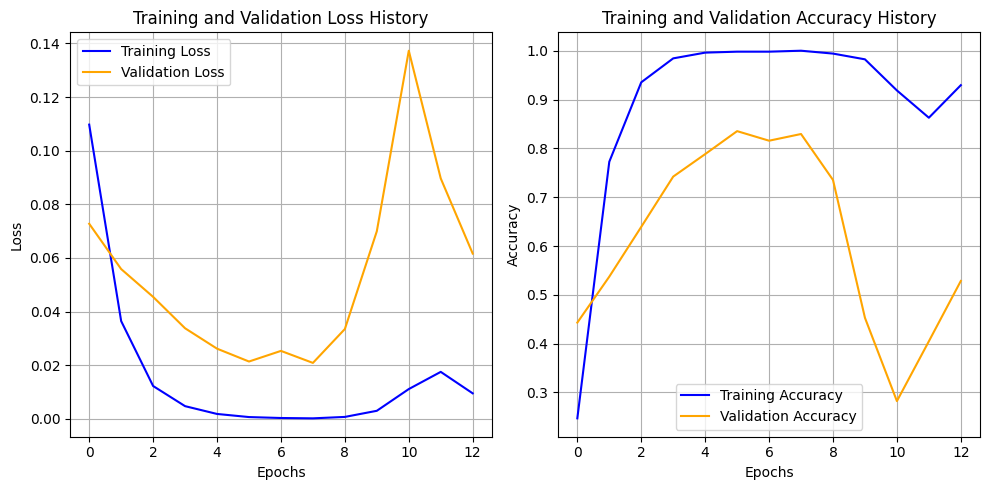

In [9]:
def plot_loss_and_accuracy(train_losses_history, train_accuracies_history, val_losses_history, val_accuracies_history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(train_losses_history, label='Training Loss', color='blue')
    ax1.plot(val_losses_history, label='Validation Loss', color='orange')
    ax1.set_title('Training and Validation Loss History')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid()

    ax2.plot(train_accuracies_history, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies_history, label='Validation Accuracy', color='orange')
    ax2.set_title('Training and Validation Accuracy History')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid()

    plt.tight_layout() 
    plt.show()
plot_loss_and_accuracy(train_losses_history, train_accuracies_history, val_losses_history, val_accuracies_history)

Below is the accuracy of the baseline ResNet-18 model when evaluated on the test set.

In [ ]:
def test_model(model_path):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 102)  # 102 flower classes
    loss_fn = nn.CrossEntropyLoss()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():  # Disable gradient calculation during inference
        test_loss = 0
        total = 0
        correct = 0
        for inputs, labels in test_loader:
            # forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)  # Compute loss

            # accumulate loss for reporting
            test_loss += loss.item()

            # calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # final evaluation metrics
    accuracy = 100 * correct / total
    average_loss = test_loss / len(test_loader)

    print(f'Evaluating model {model_path} on test set')
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Test Loss: {average_loss:.4f}")
    print()

test_model('baseline_resnet18.pth')

C:\Users\Sheryl\AppData\Local\Temp\ipykernel_26628\2944447249.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating model baseline_resnet18.pth on test set
Test Accuracy: 84.76%
Test Loss: 0.6199



### Finetuning Pretrained ResNet-18 with different number of frozen stages using transfer learning

By utilising transfer learning, we can significantly improve the model’s performance by initializing the network with weights pretrained on ImageNet, which enables the model to capture general visual features and adapt them to the new task. This way, the model can retain the learned knowledge from ImageNet (such as basic shapes, edges, and textures) and apply it to the new task with relatively fewer training epochs. It can also make up for the smaller amount of samples in the Flowers102 dataset, and allow the model to generalize better to the data.

The lower and middle layers of ResNet-18 capture general visual features, such as edges, textures, and shapes, which are common to many image recognition tasks. Freezing these layers ensures that these features are preserved. We test freezing the first few stages of the pretrained model and then fine-tuning the later layers on the dataset.

We test the performance of the model against freezing progressively more stages of the model. This approach to freezing layers helps understand the trade-offs between having more layers to finetune the model, which makes it more specific to the task, and retaining earlier layers to use as a general feature extractor, which relies on its pre-trained weights. 

In [10]:
# hyperparameter tuning for resnet model and number of frozen stages
def set_model_frozen_stages(model, num_frozen_stages):
    # freeze the beginning layers
    for param in model.conv1.parameters():
        param.requires_grad = False
    for param in model.bn1.parameters():
        param.requires_grad = False
    for param in model.relu.parameters():
        param.requires_grad = False
    for param in model.maxpool.parameters():
        param.requires_grad = False
    layers_to_freeze = [f'layer{i}' for i in range(1, num_frozen_stages+1, 1)]
    for name, child in model.named_children():
        # freeze the specified number of stages
        for i, (name, child) in enumerate(model.named_children()):
            if name in layers_to_freeze:
                for param in child.parameters():
                    param.requires_grad = False
    
def determine_model_frozen_stages_hyperparams(num_frozen_stages_combinations):
    train_losses_histories = {}
    train_accuracies_histories = {}
    val_losses_histories = {}
    val_accuracies_histories = {}
    best_val_accuracies = {}
    
    for num_frozen_stages in num_frozen_stages_combinations:
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 102)  # 102 flower classes
        set_model_frozen_stages(model, num_frozen_stages)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        earlystopper = EarlyStopper(model_path=f'resnet18-{num_frozen_stages}-frozen-stages.pth')
        print(f"NOW TUNING MODEL WITH FIRST {num_frozen_stages} STAGES FROZEN")
        train_losses_history, train_accuracies_history, val_losses_history, val_accuracies_history = train_model(model, train_loader, val_loader, loss_fn, optimizer, earlystopper, num_epochs=100)
        train_losses_histories[num_frozen_stages] = train_losses_history
        train_accuracies_histories[num_frozen_stages] = train_accuracies_history
        val_losses_histories[num_frozen_stages] = val_losses_history   
        val_accuracies_histories[num_frozen_stages] = val_accuracies_history
        best_val_accuracies[num_frozen_stages] = max(val_accuracies_history)
    return train_losses_histories, train_accuracies_histories, val_losses_histories, val_accuracies_histories, best_val_accuracies

train_losses_histories_resnet18, train_accuracies_histories_resnet18, val_losses_histories_resnet18, val_accuracies_histories_resnet18, best_val_accuracies_resnet18 = determine_model_frozen_stages_hyperparams(num_frozen_stages_combinations=[0,1,2,3,4])
    

NOW TUNING MODEL WITH FIRST 0 STAGES FROZEN
Epoch [0/100], Train Loss: 0.1093, Train Accuracy: 0.2706, Validation Loss: 0.0796, Validation Accuracy: 0.3833
Epoch [1/100], Train Loss: 0.0366, Train Accuracy: 0.7529, Validation Loss: 0.0497, Validation Accuracy: 0.5912
Epoch [2/100], Train Loss: 0.0121, Train Accuracy: 0.9353, Validation Loss: 0.0464, Validation Accuracy: 0.6353
Epoch [3/100], Train Loss: 0.0041, Train Accuracy: 0.9804, Validation Loss: 0.0408, Validation Accuracy: 0.6931
Epoch [4/100], Train Loss: 0.0024, Train Accuracy: 0.9941, Validation Loss: 0.0293, Validation Accuracy: 0.7608
Epoch [5/100], Train Loss: 0.0008, Train Accuracy: 1.0000, Validation Loss: 0.0231, Validation Accuracy: 0.8108
Epoch [6/100], Train Loss: 0.0003, Train Accuracy: 1.0000, Validation Loss: 0.0193, Validation Accuracy: 0.8382
Epoch [7/100], Train Loss: 0.0002, Train Accuracy: 1.0000, Validation Loss: 0.0181, Validation Accuracy: 0.8559
Epoch [8/100], Train Loss: 0.0001, Train Accuracy: 1.0000, V

### Visualising histories of train and validation losses and accuracies of pretrained ResNet-18 models with frozen stages

To visualise the performance of the models based on their number of frozen stages, we plot the training and validation loss and accuracy curves of the models. We also plot the best validation accuracies achieved by the models.

From the results below, it can be seen that the best-performing model is the pretrained ResNet-18 with all stages frozen, i.e. only the fully connected layer was unfrozen to be finetuned. This model achieved the best validation accuracy of 92.75%, and a test accuracy of 88.75%, outperforming the baseline ResNet-18 without pretraining.

As progressively more stages are frozen, the model's validation accuracy increases, indicating that retaining the pretrained layers helps the model generalize better to the Flowers102 dataset up to a certain point. However, at the point where all 4 stages are frozen (meaning that only the fully connected layer is available for finetuning), the validation accuracy then drops to a relatively low accuracy of 85.69% which is the lowest out of all the models. This model achieved a test accuracy of 81.54% which is lower than the test accuracy of the baseline model. This indicates that freezing all the layers from transfer learning is not always a good approach, as freezing too many layers, especially the intermediate and deeper layers, limits the model’s ability to learn task-specific features, leading to a decrease in performance. Thus, the optimal strategy involves freezing only the early layers while allowing some later layers to be fine-tuned for the task at hand.

Overall, this outcome highlights the effectiveness of transfer learning for small datasets like Flowers102. Freezing the early stages of a pretrained model, which capture general features like edges and textures, allows the model to retain useful ImageNet knowledge, while fine-tuning the later stages enables adaptation to the specific, fine-grained characteristics of flower species. We found that freezing the first 3 stages of ResNet-18 struck the best balance, achieving the highest test accuracy of 88.78% by preventing overfitting yet allowing the model to learn flower-specific details.

{0: 0.8764705882352941, 1: 0.8911764705882353, 2: 0.9088235294117647, 3: 0.9274509803921569, 4: 0.8568627450980392}


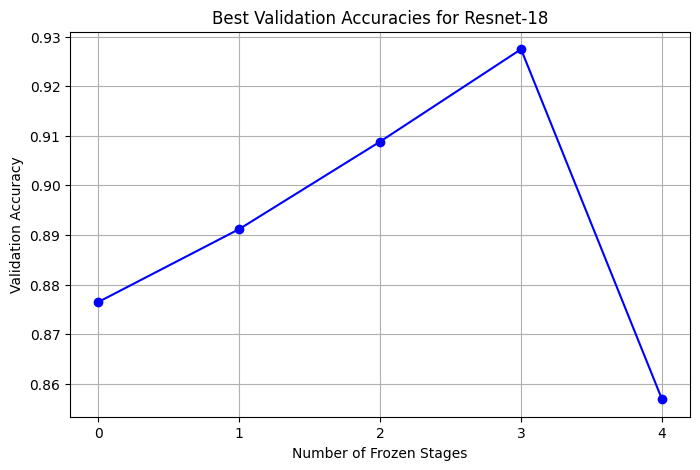

In [11]:
# Data for best validation accuracies
print(best_val_accuracies_resnet18)

epochs = list(best_val_accuracies_resnet18.keys())
accuracies = list(best_val_accuracies_resnet18.values())

plt.figure(figsize=(8, 5))
plt.plot(epochs, accuracies, marker='o', linestyle='-', color='b')
plt.title('Best Validation Accuracies for Resnet-18')
plt.xlabel('Number of Frozen Stages')
plt.ylabel('Validation Accuracy')
plt.xticks(epochs)
plt.grid()

# Show the plot
plt.show()

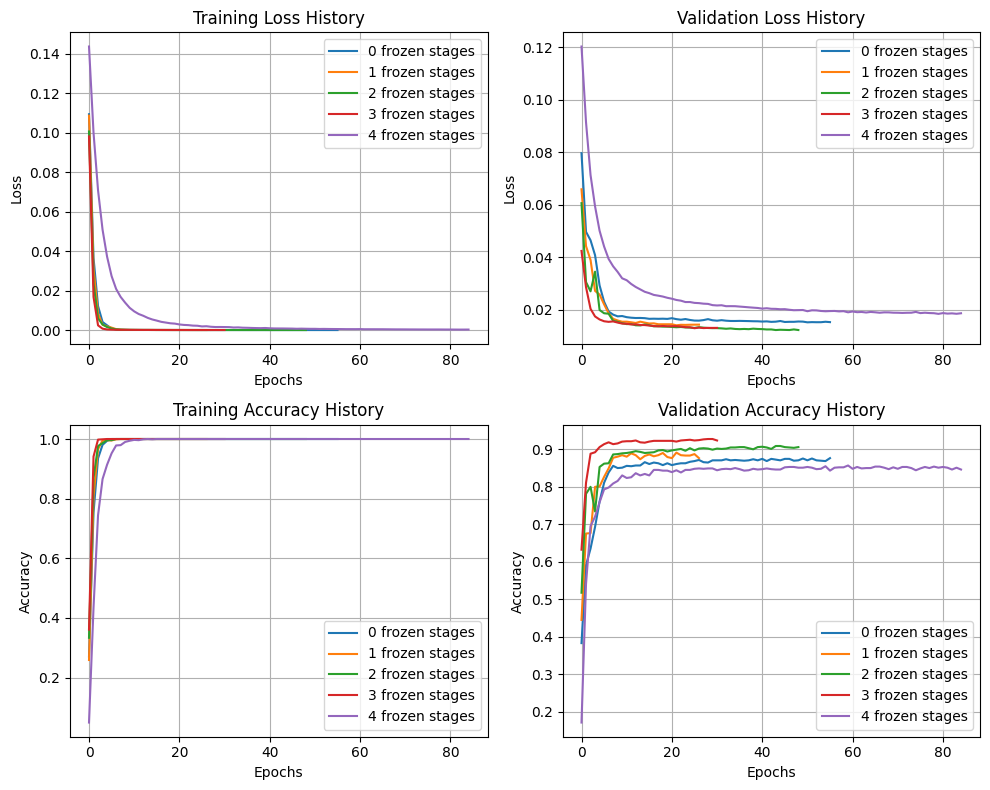

In [12]:
def plot_loss_accuracy_histories_hyperparams(train_losses_histories, train_accuracies_histories, val_losses_histories, val_accuracies_histories):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
    for key in train_losses_histories:
        ax1.plot(train_losses_histories[key], label=f'{key} frozen stages')
    ax1.set_title('Training Loss History')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid()
    for key in train_losses_histories:
        ax2.plot(val_losses_histories[key], label=f'{key} frozen stages')
    ax2.set_title('Validation Loss History')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid()

    for key in train_accuracies_histories:
        ax3.plot(train_accuracies_histories[key], label=f'{key} frozen stages')
    ax3.set_title('Training Accuracy History')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Accuracy')
    ax3.legend()
    ax3.grid()
    for key in val_accuracies_histories:
        ax4.plot(val_accuracies_histories[key], label=f'{key} frozen stages')
    ax4.set_title('Validation Accuracy History')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Accuracy')
    ax4.legend()
    ax4.grid()
    plt.tight_layout() 
    plt.show()
plot_loss_accuracy_histories_hyperparams(train_losses_histories_resnet18, train_accuracies_histories_resnet18, val_losses_histories_resnet18, val_accuracies_histories_resnet18)

In [16]:
test_model('resnet18-3-frozen-stages.pth')
test_model('resnet18-4-frozen-stages.pth')

C:\Users\Sheryl\AppData\Local\Temp\ipykernel_26628\2944447249.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating model resnet18-3-frozen-stages.pth on test set
Test Accuracy: 88.16%
Test Loss: 0.5384

Evaluating model resnet18-4-frozen-stages.pth on test set
Test Accuracy: 81.54%
Test Loss: 0.7244



### Finetuning Pretrained ResNet-34 with different number of frozen stages using transfer learning

Based on the promising results on ResNet-18, we additionally attempted to finetune the deeper ResNet-34 model using the same methodology of progressively freezing more stages of the model. ResNet-34 also has 4 stages, with the different that each stage has a higher number of residual blocks.

Since ResNet-34 is a deeper network, it has more layers and potentially more capacity to learn complex feature representations, which might influence its performance on the Flowers102 dataset. But at the same time, the deeper network may potentially lead to overfitting on the data. The goal of this experiment was to assess whether the deeper architecture could improve performance and if the same freezing strategy would apply similarly or differently to the ResNet-34 model.

In [14]:
# hyperparameter tuning for resnet model and number of frozen stages
    
def determine_model_frozen_stages_hyperparams_resnet34(num_frozen_stages_combinations):
    train_losses_histories = {}
    train_accuracies_histories = {}
    val_losses_histories = {}
    val_accuracies_histories = {}
    best_val_accuracies = {}
    
    for num_frozen_stages in num_frozen_stages_combinations:
        model = models.resnet34(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 102)  # 102 flower classes
        set_model_frozen_stages(model, num_frozen_stages)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        earlystopper = EarlyStopper(model_path=f'resnet34-{num_frozen_stages}-frozen-stages.pth')
        print(f"NOW TUNING MODEL WITH FIRST {num_frozen_stages} STAGES FROZEN")
        train_losses_history, train_accuracies_history, val_losses_history, val_accuracies_history = train_model(model, train_loader, val_loader, loss_fn, optimizer, earlystopper, num_epochs=100)
        train_losses_histories[num_frozen_stages] = train_losses_history
        train_accuracies_histories[num_frozen_stages] = train_accuracies_history
        val_losses_histories[num_frozen_stages] = val_losses_history   
        val_accuracies_histories[num_frozen_stages] = val_accuracies_history
        best_val_accuracies[num_frozen_stages] = max(val_accuracies_history)
    return train_losses_histories, train_accuracies_histories, val_losses_histories, val_accuracies_histories, best_val_accuracies

train_losses_histories_resnet34, train_accuracies_histories_resnet34, val_losses_histories_resnet34, val_accuracies_histories_resnet34, best_val_accuracies_resnet34  = determine_model_frozen_stages_hyperparams_resnet34(num_frozen_stages_combinations=[1,2,3,4])
    

c:\Users\Sheryl\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NOW TUNING MODEL WITH FIRST 1 STAGES FROZEN
Epoch [0/100], Train Loss: 0.1121, Train Accuracy: 0.2186, Validation Loss: 0.1023, Validation Accuracy: 0.2294
Epoch [1/100], Train Loss: 0.0548, Train Accuracy: 0.5578, Validation Loss: 0.0746, Validation Accuracy: 0.3980
Epoch [2/100], Train Loss: 0.0277, Train Accuracy: 0.7775, Validation Loss: 0.0705, Validation Accuracy: 0.4529
Epoch [3/100], Train Loss: 0.0161, Train Accuracy: 0.8765, Validation Loss: 0.0411, Validation Accuracy: 0.6412
Epoch [4/100], Train Loss: 0.0091, Train Accuracy: 0.9392, Validation Loss: 0.0350, Validation Accuracy: 0.7118
Epoch [5/100], Train Loss: 0.0088, Train Accuracy: 0.9314, Validation Loss: 0.0468, Validation Accuracy: 0.6059
Epoch [6/100], Train Loss: 0.0074, Train Accuracy: 0.9431, Validation Loss: 0.0536, Validation Accuracy: 0.6088
Epoch [7/100], Train Loss: 0.0046, Train Accuracy: 0.9696, Validation Loss: 0.0420, Validation Accuracy: 0.6696
Epoch [8/100], Train Loss: 0.0039, Train Accuracy: 0.9716, V

### Visualising histories of train and validation losses and accuracies of pretrained ResNet-34 models with frozen stages

To visualise the performance of the models based on their number of frozen stages, we plot the training and validation loss and accuracy curves of the models. We also plot the best validation accuracies achieved by the models.

From the results below, it can be seen that the trend of the ResNet-34 models' performance on the validation set matches the trend by ResNet-18 models. That is, as progressively more stages are frozen, the model's validation accuracy increases, indicating that retaining the pretrained layers helps the model generalize better to the Flowers102 dataset up to a certain point. However, at the point where all 4 stages are frozen (meaning that only the fully connected layer is available for finetuning), the validation accuracy then drops. The best performing model here also has 3 frozen stages, achieving a best validation accuracy of 91.18%.

However, it can be seen that all of the ResNet-34 models are outperformed by their corresponding ResNet-18 model in terms of best validation accuracy. Additionally, the best-performing ResNet-34 model achieved a test accuracy of 81.62%, which was lower than both the test accuracy of the baseline model which at 84.76% and the test accuracy of the baseline model at 88.16%.

ResNet-34, despite its greater depth and higher parameter count, underperformed due to overfitting on this small dataset, demonstrating that deeper models are not always advantageous for scenarios where the training dataset is small.

{1: 0.7411764705882353, 2: 0.8196078431372549, 3: 0.9117647058823529, 4: 0.8382352941176471}


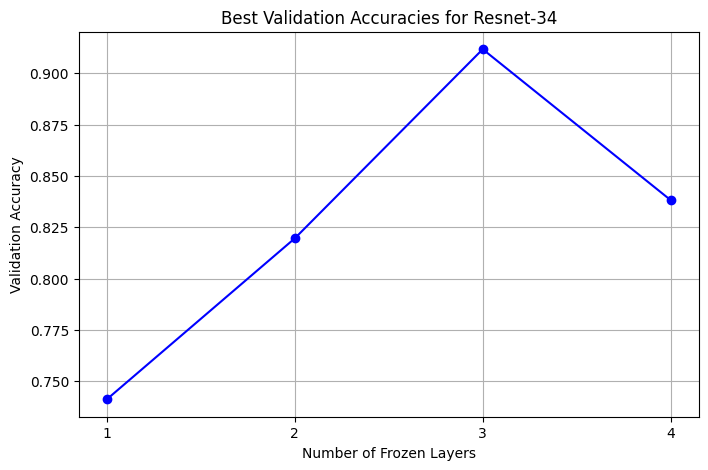

In [15]:
# Data for best validation accuracies
print(best_val_accuracies_resnet34)

epochs = list(best_val_accuracies_resnet34.keys())
accuracies = list(best_val_accuracies_resnet34.values())

plt.figure(figsize=(8, 5))
plt.plot(epochs, accuracies, marker='o', linestyle='-', color='b')
plt.title('Best Validation Accuracies for Resnet-34')
plt.xlabel('Number of Frozen Layers')
plt.ylabel('Validation Accuracy')
plt.xticks(epochs)
plt.grid()

# Show the plot
plt.show()

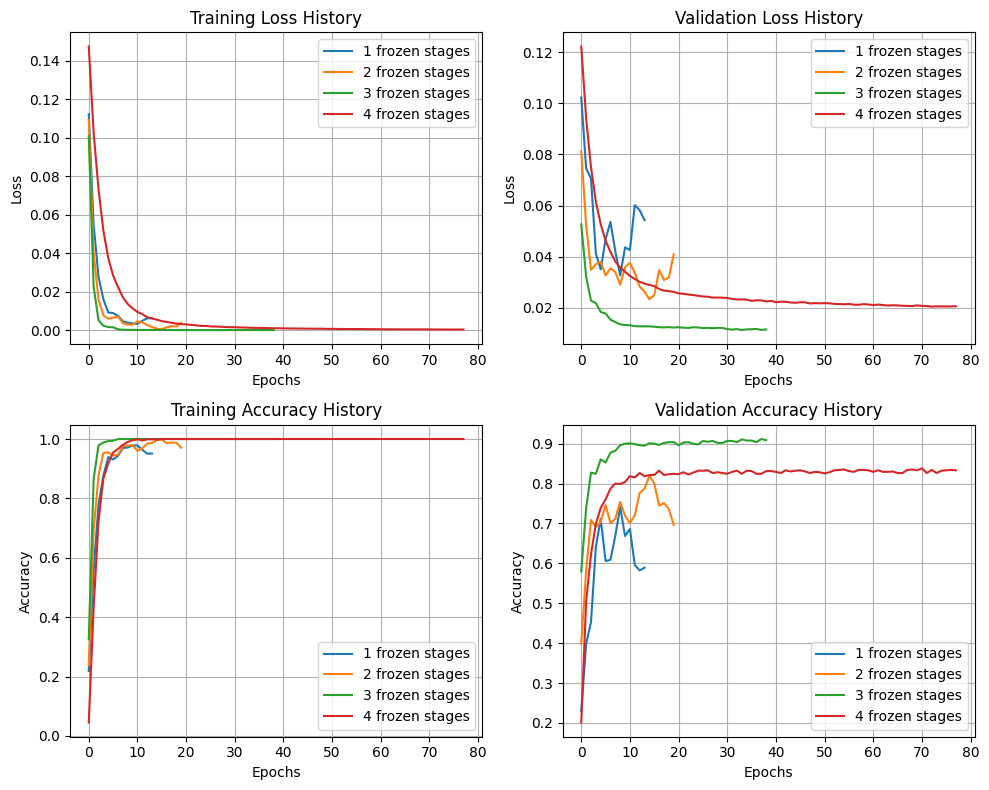

In [16]:
plot_loss_accuracy_histories_hyperparams(train_losses_histories_resnet34, train_accuracies_histories_resnet34, val_losses_histories_resnet34, val_accuracies_histories_resnet34)

In [23]:
def test_model_resnet34(model_path):
    model = models.resnet34(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 102)  # 102 flower classes
    loss_fn = nn.CrossEntropyLoss()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():  # Disable gradient calculation during inference
        test_loss = 0
        total = 0
        correct = 0
        for inputs, labels in test_loader:
            # forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)  # Compute loss

            # accumulate loss for reporting
            test_loss += loss.item()

            # calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # final evaluation metrics
    accuracy = 100 * correct / total
    average_loss = test_loss / len(test_loader)

    print(f'Evaluating model {model_path} on test set')
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Test Loss: {average_loss:.4f}")
    print()

test_model_resnet34('resnet34-3-frozen-stages.pth')

C:\Users\Sheryl\AppData\Local\Temp\ipykernel_26628\4154547857.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating model resnet34-3-frozen-stages.pth on test set
Test Accuracy: 81.62%
Test Loss: 0.7182

